In [1]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Network (now predicts only the median)
class NextStateMedianNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NextStateMedianNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, state_dim)  # Single output per state dim

    def forward(self, state, action):
        if len(state.shape) == 1:
            x = torch.cat((action, state))
        else:
            x = torch.cat((action, state), dim=1) # .unsqueeze(1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

def quantile_loss_median(predicted, target):
    error = target - predicted
    quantile = torch.tensor(0.5)
    loss = torch.max(
        quantile * error,
        (quantile - 1) * error
    )
    return loss.mean()

def mse_loss(predicted, target):
    error = target - predicted
    return error.pow(2).mean()
    

Test where I removed the quadratic part, need to put the threshold back to 1 to back to standard.

In [ ]:
class NextStateQuantileNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, num_quantiles):
        super(NextStateQuantileNetwork, self).__init__()
        self.num_quantiles = num_quantiles

        # Input layer (state + action concatenation)
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, state_dim * num_quantiles)  # Output quantiles for each state dimension
        # self.layer3 = torch.tanh(256, state_dim * num_quantiles)  # Output quantiles for each state dimension

    def forward(self, state, action):
        # Concatenate state and action
        # x = torch.cat((action, state))
        # print("action ", action, "\n")
        
        # print("state ", state, "\n")
        # print("state.shape ", state.shape, "\n")
        # print("action ", action, "\n")
        # print("action.shape ", action.shape, "\n")
        
        if len(state.shape) == 1:
            x = torch.cat((action, state))
        else:
            x = torch.cat((action, state), dim=1) # .unsqueeze(1)
            
        # print("x ", x, "\n")
        # print("x.shape ", x.shape, "\n")
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x.view(-1, self.num_quantiles, state.size(-1))


def quantile_huber_loss(predicted, target, quantiles, batch_size=32):
    """
    Calculate Quantile Huber Loss.
    :param predicted: Predicted quantiles, shape (batch_size, state_dim, num_quantiles)
    :param target: Target next state, shape (batch_size, state_dim)
    :param quantiles: Quantiles (e.g., [0.1, 0.3, 0.7, 0.9]), shape (num_quantiles,)
    """
    
    # print("target.shape ", target.shape, "\n")
    # print("target ", target, "\n")
    # target = target.unsqueeze(-1)  # Shape: (batch_size, state_dim, 1)
    target = target.unsqueeze(1).repeat(1,len(quantiles),1)
    # print("target ", target, "\n")
    # print("predicted ", predicted, "\n")
    # print("target.shape ", target.shape, "\n")
    # print("predicted.shape ", predicted.shape, "\n")
    
    error = target - predicted  # Shape: (batch_size, state_dim, num_quantiles)
    
    # print("error ", error, "\n")
    quantiles = quantiles.view(1, -1, 1)
    quantiles = quantiles.repeat(batch_size, 1, target.shape[-1])  # Shape: [3, 4, 2]
    # quantiles = quantiles.repeat(batch_size, target.shape[-1], 1) 
    # quantiles = quantiles.transpose(1, 2)  # Shape: [3, 2, 4]
    # print("quantiles ", quantiles, "\n")
    
    # # Make delta adaptive by scaling it based on quantiles
    # delta = 1.0
    # adaptive_delta = delta * (1.0 + torch.abs(quantiles - 0.5))  # Give more tolerance to extreme quantiles
    
    # # print("quantiles.shape ", quantiles.shape, "\n")
    # # Calculate loss
    # huber_loss = torch.where(
    #     error.abs() <= 0.0, # 1.0
    #     0.5 * error.pow(2),
    #     error.abs() - 0.5
    # )

    # # huber_loss = error.abs()-0.5  # Simple L1 loss
    
    # # print("huber_loss ", huber_loss, "\n")
    # # print("huber_loss.shape ", huber_loss.shape, "\n")
    
    # # Quantile loss computation
    # quantile_loss = (quantiles - (error < 0).float()).abs() * huber_loss

    # Standard Quantile Loss (Pinball Loss)
    quantile_loss = torch.max(
        quantiles * error,
        (quantiles - 1) * error
    )

    return quantile_loss.mean()

    # Quantile loss computation
    # quantile_loss = torch.abs(quantiles - (error.detach() < 0).float()) * huber_loss
    # return quantile_loss.sum(dim=1).mean()

# def quantile_huber_loss(predicted, target, quantiles, batch_size=32):
#     """
#     Calculate Quantile Huber Loss.
#     :param predicted: Predicted quantiles, shape (batch_size, state_dim, num_quantiles)
#     :param target: Target next state, shape (batch_size, state_dim)
#     :param quantiles: Quantiles (e.g., [0.1, 0.3, 0.7, 0.9]), shape (num_quantiles,)
#     """
    
#     # print("target.shape ", target.shape, "\n")
#     # print("target ", target, "\n")
#     # target = target.unsqueeze(-1)  # Shape: (batch_size, state_dim, 1)
#     target = target.unsqueeze(1).repeat(1,len(quantiles),1)
#     print("target ", target, "\n")
#     print("predicted ", predicted, "\n")
#     print("target.shape ", target.shape, "\n")
#     print("predicted.shape ", predicted.shape, "\n")
    
#     error = target - predicted  # Shape: (batch_size, state_dim, num_quantiles)
    
#     # print("error ", error, "\n")
#     quantiles = quantiles.view(1, -1, 1)
#     quantiles = quantiles.repeat(batch_size, 1, target.shape[-1])  # Shape: [3, 4, 2]
#     # quantiles = quantiles.repeat(batch_size, target.shape[-1], 1) 
#     # quantiles = quantiles.transpose(1, 2)  # Shape: [3, 2, 4]
#     print("quantiles ", quantiles, "\n")
    
#     # print("quantiles.shape ", quantiles.shape, "\n")
#     # Calculate loss
#     huber_loss = torch.where(
#         error.abs() <= 1.0,
#         0.5 * error.pow(2),
#         error.abs() - 0.5
#     )
    
#     # print("huber_loss ", huber_loss, "\n")
#     # print("huber_loss.shape ", huber_loss.shape, "\n")
    
#     # Quantile loss computation
#     # quantile_loss = (quantiles - (error < 0).float()).abs() * huber_loss
#     # return quantile_loss.mean()

#     # Quantile loss computation
#     quantile_loss = torch.abs(quantiles - (error.detach() < 0).float()) * huber_loss
#     return quantile_loss.sum(dim=1).mean()


Graph of number of values below the different quantiles graph and calculation functions


In [ ]:
def plot_nb_below_quantiles(nb_belowq1_list, nb_belowq2_list, nb_belowq3_list, nb_belowq4_list, nb_belowq5_list, nb_belowq6_list, nb_belowq7_list, nb_belowq8_list, nb_belowq9_list, nb_belowq10_list, variable):
    
    if variable == "theta":
        variable = r"$\theta$"

    plt.figure(1)
    # plt.plot(nb_belowq1_list, label=f'quantile1_{variable}')
    # plt.plot(nb_belowq2_list, label=f'quantile2_{variable}')
    # plt.plot(nb_belowq3_list, label=f'quantile3_{variable}')
    # plt.plot(nb_belowq4_list, label=f'quantile4_{variable}')
    # plt.plot(nb_belowq5_list, label=f'quantile5_{variable}')
    # plt.plot(nb_belowq6_list, label=f'quantile6_{variable}')
    # plt.plot(nb_belowq7_list, label=f'quantile7_{variable}')
    # plt.plot(nb_belowq8_list, label=f'quantile8_{variable}')
    # plt.plot(nb_belowq9_list, label=f'quantile9_{variable}')
    # plt.plot(nb_belowq10_list, label=f'quantile10_{variable}')
    plt.plot(nb_belowq1_list, label=f'Q1_{variable}')
    plt.plot(nb_belowq2_list, label=f'Q2_{variable}')
    plt.plot(nb_belowq3_list, label=f'Q3_{variable}')
    plt.plot(nb_belowq4_list, label=f'Q4_{variable}')
    plt.plot(nb_belowq5_list, label=f'Q5_{variable}')
    plt.plot(nb_belowq6_list, label=f'Q6_{variable}')
    plt.plot(nb_belowq7_list, label=f'Q7_{variable}')
    plt.plot(nb_belowq8_list, label=f'Q8_{variable}')
    plt.plot(nb_belowq9_list, label=f'Q9_{variable}')
    plt.plot(nb_belowq10_list, label=f'Q10_{variable}')
    plt.hlines(0.1, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile1'
    plt.hlines(0.2, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile2'
    plt.hlines(0.3, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile3'
    plt.hlines(0.4, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile4'
    plt.hlines(0.5, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile5'
    plt.hlines(0.6, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile6'
    plt.hlines(0.7, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile7'
    plt.hlines(0.8, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile8'
    plt.hlines(0.9, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile9'
    plt.hlines(1.0, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile10'
    plt.xlabel('Number of steps')
    plt.ylabel(f'Number of steps below quantile {variable}')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    

In [ ]:
def nb_below_quantile(env, quantile0, quantile1, quantile2, quantile3, quantile4, quantile5, quantile6, quantile7, quantile8, quantile9, quantile10):
    
    nb_belowq1 = 0
    nb_belowq2 = 0
    nb_belowq3 = 0
    nb_belowq4 = 0
    nb_belowq5 = 0
    nb_belowq6 = 0
    nb_belowq7 = 0
    nb_belowq8 = 0
    nb_belowq9 = 0
    nb_belowq10 = 0
    
    nb_belowq1_list = [0]
    nb_belowq2_list = [0]
    nb_belowq3_list = [0]
    nb_belowq4_list = [0]
    nb_belowq5_list = [0]
    nb_belowq6_list = [0]
    nb_belowq7_list = [0]
    nb_belowq8_list = [0]
    nb_belowq9_list = [0]
    nb_belowq10_list = [0]
    
    
    for i in range(len(quantile0)):
        
        if env[i] < quantile1[i]:
            nb_belowq1 += 1
            
        if env[i] < quantile2[i]:
            nb_belowq2 += 1
            
        if env[i] < quantile3[i]:
            nb_belowq3 += 1
            
        if env[i] < quantile4[i]:
            nb_belowq4 += 1
            
        if env[i] < quantile5[i]:
            nb_belowq5 += 1
            
        if env[i] < quantile6[i]:
            nb_belowq6 += 1
            
        if env[i] < quantile7[i]:
            nb_belowq7 += 1
            
        if env[i] < quantile8[i]:
            nb_belowq8 += 1
            
        if env[i] < quantile9[i]:
            nb_belowq9 += 1
            
        if env[i] < quantile10[i]:
            nb_belowq10 += 1

        nb_belowq1_list.append(nb_belowq1/(i+1))
        nb_belowq2_list.append(nb_belowq2/(i+1))
        nb_belowq3_list.append(nb_belowq3/(i+1))
        nb_belowq4_list.append(nb_belowq4/(i+1))
        nb_belowq5_list.append(nb_belowq5/(i+1))
        nb_belowq6_list.append(nb_belowq6/(i+1))
        nb_belowq7_list.append(nb_belowq7/(i+1))
        nb_belowq8_list.append(nb_belowq8/(i+1))
        nb_belowq9_list.append(nb_belowq9/(i+1))
        nb_belowq10_list.append(nb_belowq10/(i+1))
        
        

    return nb_belowq1_list, nb_belowq2_list, nb_belowq3_list, nb_belowq4_list, nb_belowq5_list, nb_belowq6_list, nb_belowq7_list, nb_belowq8_list, nb_belowq9_list, nb_belowq10_list


## Acrobot

When taking a step in the env, the state variables are $\cos{(\theta_1)}, \sin{(\theta_1)}, \cos{(\theta_2)}, \sin{(\theta_2)}, \omega_1, \omega_2$.

When using env.state, we have $\theta_1, \theta_2, \omega_1, \omega_2$. This allows us to have more precision in the angles which is needed in the MPC cost function.

Trying different PF and pre-trained using rnd actions QRNN - Feb 5


- Train on randomly sampled actions

In [ ]:
error_magnitudes_costheta1 = []
error_magnitudes_sintheta1 = []
error_magnitudes_costheta2 = []
error_magnitudes_sintheta2 = []
error_magnitudes_omega1 = []
error_magnitudes_omega2 = []

env_costheta1 = []
env_sintheta1 = []
env_costheta2 = []
env_sintheta2 = []
env_omega1 = []
env_omega2 = []

pred_costheta1 = []
pred_sintheta1 = []
pred_costheta2 = []
pred_sintheta2 = []
pred_omega1 = []
pred_omega2 = []

# pred_x_var = []
# pred_y_var = []
# pred_z_var = []

seed = 0

env = gym.make('Acrobot-v1')#.unwrapped
sim_env = gym.make('Acrobot-v1')#.unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0]#-2#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1

# Initialize the Next-State Prediction Network
model = NextStateMedianNetwork(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = mse_loss

states_low = torch.tensor([-1, -1, -1, -1, -12.566371, -28.274334])
states_high = torch.tensor([1, 1, 1, 1, 12.566371, 28.274334])

batch_size = 32

# Experience replay buffer
replay_buffer = []
discrete = True
num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)

for step in range(num_test_steps):
    # state = env.state
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    # next_state = env.state
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # test_next_state = torch.clip(test_next_state, states_low, states_high)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        
        # Predict next state quantiles
        preds = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        # lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        # mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        # upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_costheta1 = np.append(pred_costheta1, preds[0].detach().numpy())
        pred_sintheta1 = np.append(pred_sintheta1, preds[1].detach().numpy())
        pred_costheta2 = np.append(pred_costheta2, preds[2].detach().numpy()) 
        pred_sintheta2 = np.append(pred_sintheta2, preds[3].detach().numpy())
        # pred_theta2 = np.append(pred_sintheta2, preds[3].detach().numpy())  
        pred_omega1 = np.append(pred_omega1, preds[4].detach().numpy())
        pred_omega2 = np.append(pred_omega2, preds[5].detach().numpy())
        
        deltacostheta1 = test_next_state[0] - preds[0]
        deltasintheta1 = test_next_state[1] - preds[1]
        deltacostheta2 = test_next_state[2] - preds[2]
        deltasintheta2 = test_next_state[3] - preds[3]
        deltaomega1 = test_next_state[4] - preds[4]
        deltaomega2 = test_next_state[5] - preds[5]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_costheta1.append(np.abs(deltacostheta1.detach().numpy())) # .detach().numpy()
        error_magnitudes_sintheta1.append(np.abs(deltasintheta1.detach().numpy())) # .detach().numpy()
        error_magnitudes_costheta2.append(np.abs(deltacostheta2.detach().numpy())) # .detach().numpy()
        error_magnitudes_sintheta2.append(np.abs(deltasintheta2.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega1.append(np.abs(deltaomega1.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega2.append(np.abs(deltaomega2.detach().numpy())) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_costheta1.append(test_next_state[0])
        env_sintheta1.append(test_next_state[1])
        env_costheta2.append(test_next_state[2])
        env_sintheta2.append(test_next_state[3])
        env_omega1.append(test_next_state[4])
        env_omega2.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    if discrete:
        replay_buffer.append((state, np.array([action]), reward, next_state, done))
    else:
        replay_buffer.append((state, np.array(action), reward, next_state, done))
        
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        loss = loss_func(predicted_quantiles, target_quantiles)
        
        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state
    
    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
 

In [ ]:
print("Last 100 steps")
print(np.mean(error_magnitudes_costheta1[-100:]),
      np.mean(error_magnitudes_sintheta1[-100:]),
      np.mean(error_magnitudes_costheta2[-100:]),
      np.mean(error_magnitudes_sintheta2[-100:]),
      np.mean(error_magnitudes_omega1[-100:]),
      np.mean(error_magnitudes_omega2[-100:]),)


0.012290671 0.014610466 0.018296355 0.017462563 0.028925164 0.03242891


In [18]:
print("All steps")
print(np.mean(error_magnitudes_costheta1),
      np.mean(error_magnitudes_sintheta1),
      np.mean(error_magnitudes_costheta2),
      np.mean(error_magnitudes_sintheta2),
      np.mean(error_magnitudes_omega1),
      np.mean(error_magnitudes_omega2),)


0.0148291215 0.013260001 0.015907897 0.016531052 0.0221997 0.031208333


In [23]:
print("Last 100 steps")
print(f"$\\cos(\\theta_1)$ comparison:",
np.mean(np.abs(np.array(pred_costheta1[-100:])-np.array(env_costheta1[-100:]))))

print(f"$\\sin(\\theta_1)$ comparison:",
np.mean(np.abs(np.array(pred_sintheta1[-100:])-np.array(env_sintheta1[-100:]))))

print(f"$\\cos(\\theta_2)$ comparison:",
np.mean(np.abs(np.array(pred_costheta2[-100:])-np.array(env_costheta2[-100:]))))

print(f"$\\sin(\\theta_2)$ comparison:",
np.mean(np.abs(np.array(pred_sintheta2[-100:])-np.array(env_sintheta2[-100:]))))

print(f"$(\\omega_1)$ comparison:",
np.mean(np.abs(np.array(pred_omega1[-100:])-np.array(env_omega1[-100:]))))

print(f"$(\\omega_2)$ comparison:",
np.mean(np.abs(np.array(pred_omega2[-100:])-np.array(env_omega2[-100:]))))



Last 100 steps
$\cos(\theta_1)$ comparison: 0.01229067236185074
$\sin(\theta_1)$ comparison: 0.014610465532168746
$\cos(\theta_2)$ comparison: 0.018296355810016394
$\sin(\theta_2)$ comparison: 0.01746256315294886
$(\omega_1)$ comparison: 0.028925164118409157
$(\omega_2)$ comparison: 0.032428912725299595


In [21]:
print("All steps")
print(f"$\\cos(\\theta_1)$ comparison:",
np.mean(np.abs(np.array(pred_costheta1)-np.array(env_costheta1))))

print(f"$\\sin(\\theta_1)$ comparison:",
np.mean(np.abs(np.array(pred_sintheta1)-np.array(env_sintheta1))))

print(f"$\\cos(\\theta_2)$ comparison:",
np.mean(np.abs(np.array(pred_costheta2)-np.array(env_costheta2))))

print(f"$\\sin(\\theta_2)$ comparison:",
np.mean(np.abs(np.array(pred_sintheta2)-np.array(env_sintheta2))))

print(f"$(\\omega_1)$ comparison:",
np.mean(np.abs(np.array(pred_omega1)-np.array(env_omega1))))

print(f"$(\\omega_2)$ comparison:",
np.mean(np.abs(np.array(pred_omega2)-np.array(env_omega2))))




All steps
$\cos(\theta_1)$ comparison: 0.014829121757013198
$\sin(\theta_1)$ comparison: 0.013260000583310087
$\cos(\theta_2)$ comparison: 0.015907896468723485
$\sin(\theta_2)$ comparison: 0.016531051363886308
$(\omega_1)$ comparison: 0.022199700238637595
$(\omega_2)$ comparison: 0.031208333278960332


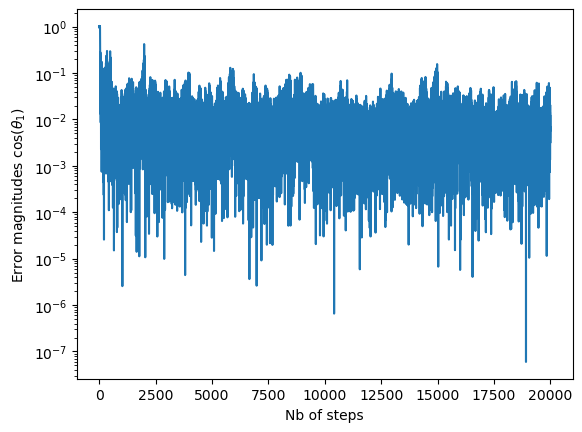

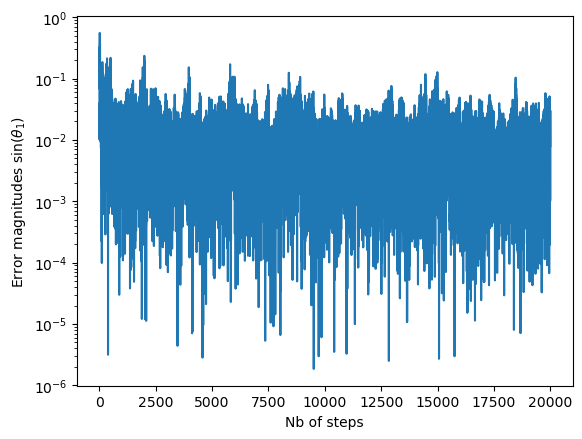

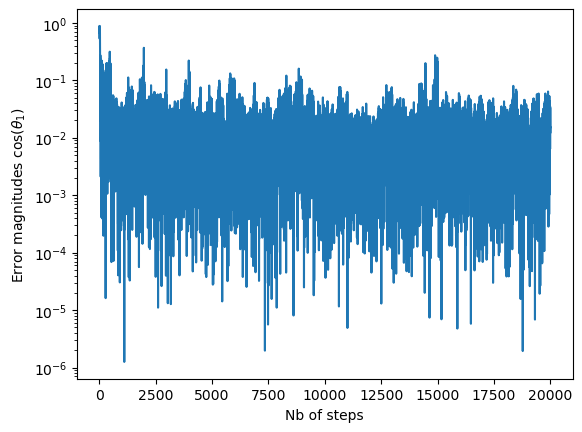

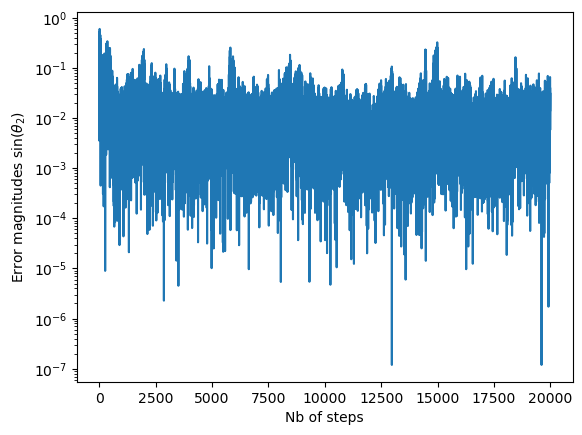

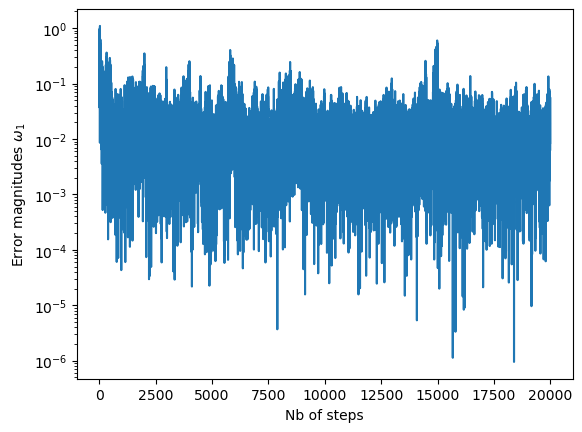

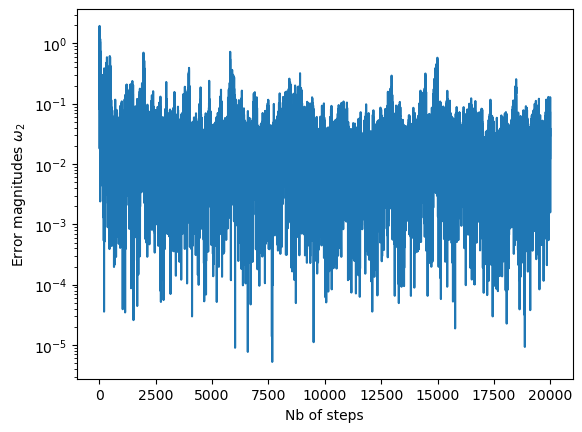

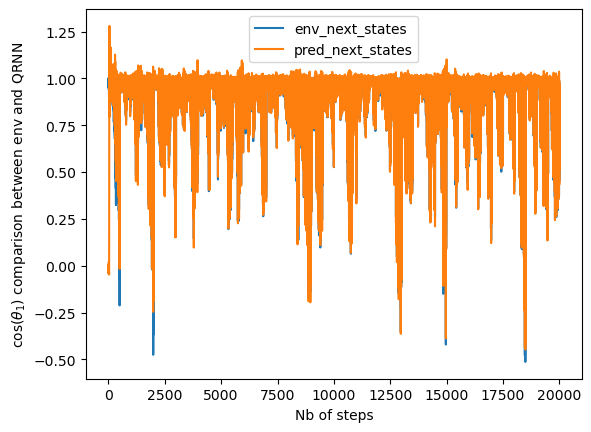

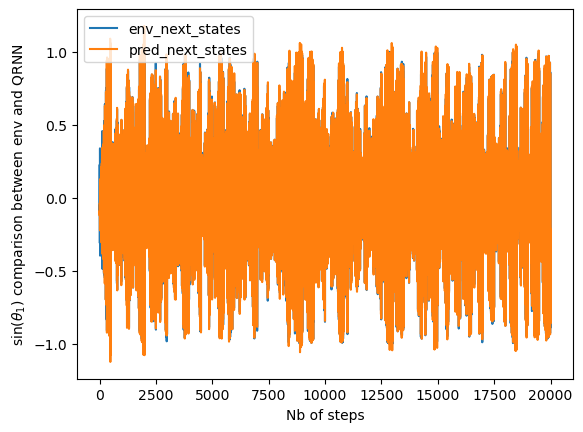

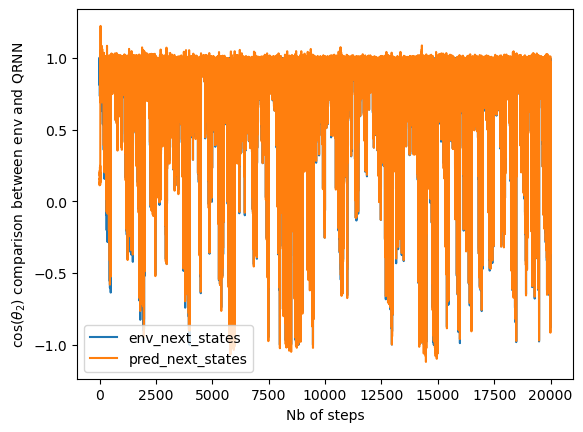

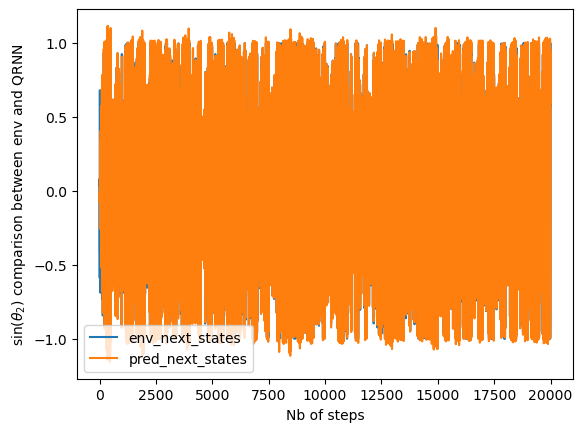

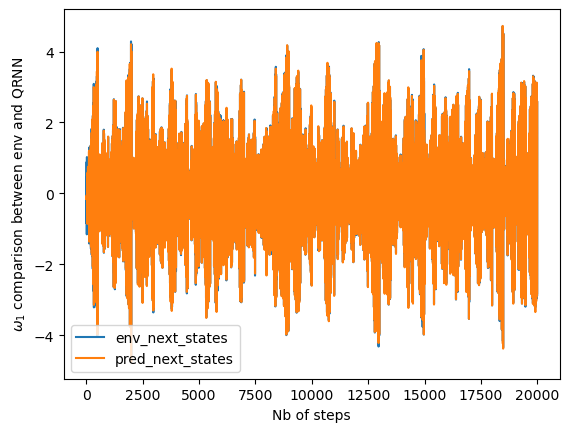

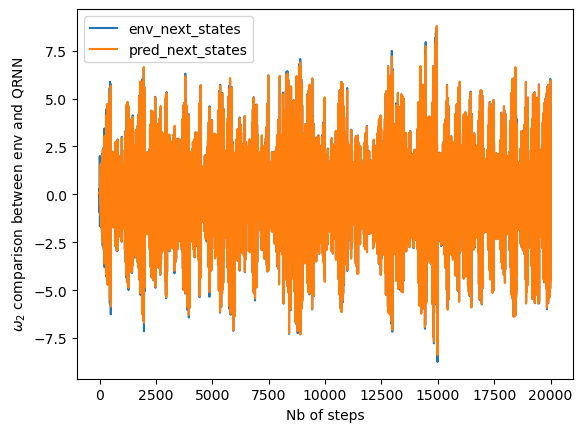

In [32]:
plt.figure(1)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_costheta1)
plt.ylabel(f'Error magnitudes $\\cos(\\theta_1)$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(2)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sintheta1)
plt.ylabel(f'Error magnitudes $\\sin(\\theta_1)$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(3)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_costheta2)
plt.ylabel(f'Error magnitudes $\\cos(\\theta_1)$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(4)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sintheta2)
plt.ylabel(f'Error magnitudes $\\sin(\\theta_2)$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(5)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega1)
plt.ylabel(f'Error magnitudes $\omega_1$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(6)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega2)
plt.ylabel(f'Error magnitudes $\omega_2$')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(7)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\\cos(\\theta_1)$ comparison between env and QRNN')
plt.plot(env_costheta1, label='env_next_states')
plt.plot(pred_costheta1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_1std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_2std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(8)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\\sin(\\theta_1)$ comparison between env and QRNN')
plt.plot(env_sintheta1, label='env_next_states')
plt.plot(pred_sintheta1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_1std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_2std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(9)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\\cos(\\theta_2)$ comparison between env and QRNN')
plt.plot(env_costheta2, label='env_next_states')
plt.plot(pred_costheta2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_1std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_2std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(10)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\\sin(\\theta_2)$ comparison between env and QRNN')
plt.plot(env_sintheta2, label='env_next_states')
plt.plot(pred_sintheta2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_1std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_2std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(11)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\omega_1$ comparison between env and QRNN')
plt.plot(env_omega1, label='env_next_states')
plt.plot(pred_omega1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_omega1)), pred_omega1 - pred_omega1_bottom_1std, pred_omega1 + pred_omega1_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_omega1)), pred_omega1 - pred_omega1_bottom_2std, pred_omega1 + pred_omega1_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(12)
plt.xlabel('Nb of steps')
plt.ylabel(f'$\omega_2$ comparison between env and QRNN')
plt.plot(env_omega2, label='env_next_states')
plt.plot(pred_omega2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_omega2)), pred_omega2 - pred_omega2_bottom_1std, pred_omega2 + pred_omega2_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_omega2)), pred_omega2 - pred_omega2_bottom_2std, pred_omega2 + pred_omega2_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()




## Cart pole

In [ ]:
error_magnitudes_x = []
error_magnitudes_v = []
error_magnitudes_theta = []
error_magnitudes_omega = []

env_x = []
env_v = []
env_theta = []
env_omega = []

pred_x = []
pred_v = []
pred_theta = []
pred_omega = []

# pred_x_var = []
# pred_y_var = []
# pred_z_var = []

seed = 0

env = gym.make('CartPole-v1')#.unwrapped
# sim_env = gym.make('CartPole-v1')#.unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0]#-2#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1

# Initialize the Next-State Prediction Network
model = NextStateMedianNetwork(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = mse_loss

states_low = torch.tensor([-4.8, -torch.inf, -0.41887903, -torch.inf])
states_high = torch.tensor([4.8, torch.inf, 0.41887903, torch.inf])

batch_size = 32

# Experience replay buffer
replay_buffer = []
discrete = True
num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)

for step in range(num_test_steps):
    # state = env.state
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    # next_state = env.state
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # test_next_state = torch.clip(test_next_state, states_low, states_high)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)
                
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        
        # Predict next state quantiles
        preds = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        # lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        # mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        # upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, preds[0].detach().numpy())
        pred_v = np.append(pred_v, preds[1].detach().numpy())
        pred_theta = np.append(pred_theta, preds[2].detach().numpy()) 
        pred_omega = np.append(pred_omega, preds[3].detach().numpy())
        # # pred_theta2 = np.append(pred_sintheta2, preds[3].detach().numpy())  
        # pred_omega1 = np.append(pred_omega1, preds[4].detach().numpy())
        # pred_omega2 = np.append(pred_omega2, preds[5].detach().numpy())
        
        deltax = test_next_state[0] - preds[0]
        deltav = test_next_state[1] - preds[1]
        deltatheta = test_next_state[2] - preds[2]
        deltaomega = test_next_state[3] - preds[3]
        # deltaomega1 = test_next_state[4] - preds[4]
        # deltaomega2 = test_next_state[5] - preds[5]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax.detach().numpy())) # .detach().numpy()
        error_magnitudes_v.append(np.abs(deltav.detach().numpy())) # .detach().numpy()
        error_magnitudes_theta.append(np.abs(deltatheta.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega.append(np.abs(deltaomega.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega1.append(np.abs(deltaomega1.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega2.append(np.abs(deltaomega2.detach().numpy())) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_v.append(test_next_state[1])
        env_theta.append(test_next_state[2])
        env_omega.append(test_next_state[3])
        # env_omega1.append(test_next_state[4])
        # env_omega2.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    if discrete:
        replay_buffer.append((state, np.array([action]), reward, next_state, done))
    else:
        replay_buffer.append((state, np.array(action), reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        loss = loss_func(predicted_quantiles, target_quantiles)
        
        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state
    
    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
 

In [40]:
print("Last 100 steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x[-100:])-np.array(env_x[-100:]))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_v[-100:])-np.array(env_v[-100:]))))

print(f"$\\theta$ comparison:",
np.mean(np.abs(np.array(pred_theta[-100:])-np.array(env_theta[-100:]))))

print(f"$\\omega$ comparison:",
np.mean(np.abs(np.array(pred_omega[-100:])-np.array(env_omega[-100:]))))


Last 100 steps
x comparison: 0.003038837304338813
v comparison: 0.0026685147918760776
$\theta$ comparison: 0.0018296745636325795
$\omega$ comparison: 0.003367922864854336


In [41]:
print("All steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x)-np.array(env_x))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_v)-np.array(env_v))))

print(f"$\\theta$ comparison:",
np.mean(np.abs(np.array(pred_theta)-np.array(env_theta))))

print(f"$\\omega$ comparison:",
np.mean(np.abs(np.array(pred_omega)-np.array(env_omega))))


All steps
x comparison: 0.003860350524151754
v comparison: 0.0054419759472422845
$\theta$ comparison: 0.0037743989147271625
$\omega$ comparison: 0.006980240567369537


Plots for cart pole env

In [ ]:
# # Plot training results
# import matplotlib.pyplot as plt
# # Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_v)
# plt.ylabel('error_magnitudes_v')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_theta)
# plt.ylabel('error_magnitudes_theta')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega)
# plt.ylabel('error_magnitudes_omega')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(7)
# plt.xlabel('Nb of steps')
# plt.ylabel('v comparison between env and QRNN')
# plt.plot(env_v, label='env_next_states')
# plt.plot(pred_v, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_v)), pred_v - pred_v_bottom_1std, pred_v + pred_v_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_v)), pred_v - pred_v_bottom_2std, pred_v + pred_v_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(8)
# plt.xlabel('Nb of steps')
# plt.ylabel('theta comparison between env and QRNN')
# plt.plot(env_theta, label='env_next_states')
# plt.plot(pred_theta, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(9)
# plt.xlabel('Nb of steps')
# plt.ylabel('omega comparison between env and QRNN')
# plt.plot(env_omega, label='env_next_states')
# plt.plot(pred_omega, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




## Pendulum 

In [ ]:
def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi



Feb 7th test using same code as for continuous MC

In [50]:
error_magnitudes_x = []
error_magnitudes_y = []
error_magnitudes_omega = []

env_x = []
env_y = []
env_omega = []

pred_x = []
pred_y = []
pred_omega = []

seed = 0
discrete = False
env = gym.make('Pendulum-v1')#.unwrapped
# sim_env = gym.make('Pendulum-v1')#.unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0]#-2#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1

# Initialize the Next-State Prediction Network
model = NextStateMedianNetwork(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = mse_loss

states_low = torch.tensor([-1, -1, -8])
states_high = torch.tensor([1, 1, 8])

batch_size = 32

# Experience replay buffer
replay_buffer = []

num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)

for step in range(num_test_steps):
    # state = env.state
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    # next_state = env.state
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # test_next_state = torch.clip(test_next_state, states_low, states_high)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        
        # Predict next state quantiles
        preds = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        # lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        # mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        # upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, preds[0].detach().numpy())
        pred_y = np.append(pred_y, preds[1].detach().numpy())
        pred_omega = np.append(pred_omega, preds[2].detach().numpy())
        # # pred_theta2 = np.append(pred_sintheta2, preds[3].detach().numpy())  
        # pred_omega1 = np.append(pred_omega1, preds[4].detach().numpy())
        # pred_omega2 = np.append(pred_omega2, preds[5].detach().numpy())
        
        deltax = test_next_state[0] - preds[0]
        deltay = test_next_state[1] - preds[1]
        deltaomega = test_next_state[2] - preds[2]
        # deltaomega = test_next_state[3] - preds[3]
        # deltaomega1 = test_next_state[4] - preds[4]
        # deltaomega2 = test_next_state[5] - preds[5]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax.detach().numpy())) # .detach().numpy()
        error_magnitudes_y.append(np.abs(deltay.detach().numpy())) # .detach().numpy()
        # error_magnitudes_theta.append(np.abs(deltatheta.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega.append(np.abs(deltaomega.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega1.append(np.abs(deltaomega1.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega2.append(np.abs(deltaomega2.detach().numpy())) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_y.append(test_next_state[1])
        env_omega.append(test_next_state[2])
        # env_omega.append(test_next_state[3])
        # env_omega1.append(test_next_state[4])
        # env_omega2.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    if discrete:
        replay_buffer.append((state, np.array([action]), reward, next_state, done))
    else:
        replay_buffer.append((state, np.array(action), reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        loss = loss_func(predicted_quantiles, target_quantiles)
        
        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state
    
    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
 

C:\Users\nicle\AppData\Local\Temp\ipykernel_29156\2758619552.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions_taken[step] = action


In [ ]:
print("Last 100 steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x[-100:])-np.array(env_x[-100:]))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_y[-100:])-np.array(env_y[-100:]))))

print(f"$\omega$ comparison:",
np.mean(np.abs(np.array(pred_omega[-100:])-np.array(env_omega[-100:]))))


Last 100 steps
x comparison: 0.013266302235424519
v comparison: 0.010118581890128552
$\omega$ comparison: 0.03192018806934357


In [55]:
print("All steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x)-np.array(env_x))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_v)-np.array(env_v))))

print(f"$\\theta$ comparison:",
np.mean(np.abs(np.array(pred_theta)-np.array(env_theta))))

print(f"$\omega$ comparison:",
np.mean(np.abs(np.array(pred_omega)-np.array(env_omega))))


All steps
x comparison: 0.01616144617321966
v comparison: 0.0054419759472422845
$\theta$ comparison: 0.0037743989147271625
$\omega$ comparison: 0.03168409860953947


Plots for the pendulum env

In [ ]:
# import matplotlib.pyplot as plt
# # # Plot the rewards
# # plt.figure(1)
# # # plt.legend()
# # # plt.grid()
# # plt.plot(episode_reward_list)
# # plt.xlabel('Nb of episodes')
# # plt.ylabel('episode reward')
# # # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')

# plt.figure(1)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_y)
# plt.ylabel('error_magnitudes_y')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega)
# plt.ylabel('error_magnitudes_omega')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')


# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('y comparison between env and QRNN')
# plt.plot(env_y, label='env_next_states')
# plt.plot(pred_y, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('omega comparison between env and QRNN')
# plt.plot(env_omega, label='env_next_states')
# plt.plot(pred_omega, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




## Mountain car

In [56]:
error_magnitudes_x = []
error_magnitudes_v = []

env_x = []
env_v = []

pred_x = []
pred_v = []

seed = 0
discrete = False
env = gym.make('MountainCarContinuous-v0')#.unwrapped
# sim_env = gym.make('Pendulum-v1')#.unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0]#-2#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1

# Initialize the Next-State Prediction Network
model = NextStateMedianNetwork(state_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = mse_loss

states_low = torch.tensor([-1.2, -0.07])
states_high = torch.tensor([0.6, 0.07])

batch_size = 32

# Experience replay buffer
replay_buffer = []

num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)

for step in range(num_test_steps):
    # state = env.state
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    # next_state = env.state
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # test_next_state = torch.clip(test_next_state, states_low, states_high)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        
        # Predict next state quantiles
        preds = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        # lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        # mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        # upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, preds[0].detach().numpy())
        pred_v = np.append(pred_v, preds[1].detach().numpy())
        # pred_omega = np.append(pred_omega, preds[2].detach().numpy())
        # # pred_theta2 = np.append(pred_sintheta2, preds[3].detach().numpy())  
        # pred_omega1 = np.append(pred_omega1, preds[4].detach().numpy())
        # pred_omega2 = np.append(pred_omega2, preds[5].detach().numpy())
        
        deltax = test_next_state[0] - preds[0]
        deltav = test_next_state[1] - preds[1]
        # deltaomega = test_next_state[2] - preds[2]
        # deltaomega = test_next_state[3] - preds[3]
        # deltaomega1 = test_next_state[4] - preds[4]
        # deltaomega2 = test_next_state[5] - preds[5]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax.detach().numpy())) # .detach().numpy()
        error_magnitudes_v.append(np.abs(deltav.detach().numpy())) # .detach().numpy()
        # error_magnitudes_theta.append(np.abs(deltatheta.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega.append(np.abs(deltaomega.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega1.append(np.abs(deltaomega1.detach().numpy())) # .detach().numpy()
        # error_magnitudes_omega2.append(np.abs(deltaomega2.detach().numpy())) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_v.append(test_next_state[1])
        # env_omega.append(test_next_state[2])
        # env_omega.append(test_next_state[3])
        # env_omega1.append(test_next_state[4])
        # env_omega2.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    if discrete:
        replay_buffer.append((state, np.array([action]), reward, next_state, done))
    else:
        replay_buffer.append((state, np.array(action), reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        loss = loss_func(predicted_quantiles, target_quantiles)
        
        # # Compute Quantile Huber Loss
        # loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state
    
    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
 







C:\Users\nicle\AppData\Local\Temp\ipykernel_29156\3837950229.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions_taken[step] = action


In [57]:
print("Last 100 steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x[-100:])-np.array(env_x[-100:]))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_v[-100:])-np.array(env_v[-100:]))))



Last 100 steps
x comparison: 0.0014421991076960694
v comparison: 0.0011489635848556646


In [58]:
print("All steps")
print(f"x comparison:",
np.mean(np.abs(np.array(pred_x)-np.array(env_x))))

print(f"v comparison:",
np.mean(np.abs(np.array(pred_v)-np.array(env_v))))



All steps
x comparison: 0.003205451993430827
v comparison: 0.0013036022130923943


Plots for continuous MC env

In [ ]:
# import matplotlib.pyplot as plt
# # # Plot the rewards
# # plt.figure(1)
# # # plt.legend()
# # # plt.grid()
# # plt.plot(episode_reward_list)
# # plt.xlabel('Nb of episodes')
# # plt.ylabel('episode reward')
# # # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_v)
# plt.ylabel('error_magnitudes_v')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')


# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('v comparison between env and QRNN')
# plt.plot(env_v, label='env_next_states')
# plt.plot(pred_v, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




## Panda Dense reward Reach (3D)

Graphs

In [ ]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# # Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_y)
# plt.ylabel('error_magnitudes_y')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_z)
# plt.ylabel('error_magnitudes_z')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('y comparison between env and QRNN')
# plt.plot(env_y, label='env_next_states')
# plt.plot(pred_y, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(7)
# plt.xlabel('Nb of steps')
# plt.ylabel('z comparison between env and QRNN')
# plt.plot(env_z, label='env_next_states')
# plt.plot(pred_z, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_1std, pred_z + pred_z_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_2std, pred_z + pred_z_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(8)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vx)
# plt.ylabel('error_magnitudes_vx')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(9)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vy)
# plt.ylabel('error_magnitudes_vy')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(10)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vz)
# plt.ylabel('error_magnitudes_vz')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(11)
# plt.xlabel('Nb of steps')
# plt.ylabel('vx comparison between env and QRNN')
# plt.plot(env_vx, label='env_next_states')
# plt.plot(pred_vx, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(12)
# plt.xlabel('Nb of steps')
# plt.ylabel('vy comparison between env and QRNN')
# plt.plot(env_vy, label='env_next_states')
# plt.plot(pred_vy, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(13)
# plt.xlabel('Nb of steps')
# plt.ylabel('vz comparison between env and QRNN')
# plt.plot(env_vz, label='env_next_states')
# plt.plot(pred_vz, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_1std, pred_z + pred_z_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_2std, pred_z + pred_z_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()



## MuJoCo Reacher (2D)


Run

In [ ]:
import panda_gym
%matplotlib inline

horizon = 15

seed = 42
max_episodes = 100 # 300
max_episode_steps = 50 #1000
env = gym.make('Reacher-v5').unwrapped # , render_mode='human'
sim_env = gym.make('Reacher-v5').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)
# np.random.seed(seed)
# random.seed(seed)

error_magnitudes_cos1 = []
error_magnitudes_cos2 = []
error_magnitudes_sin1 = []
error_magnitudes_sin2 = []
error_magnitudes_omega1 = []
error_magnitudes_omega2 = []
error_magnitudes_xdist = []
error_magnitudes_ydist = []

env_cos1 = []
env_cos2 = []
env_sin1 = []
env_sin2 = []
env_omega1 = []
env_omega2 = []
env_xdist = []
env_ydist = []

pred_cos1 = []
pred_cos2 = []
pred_sin1 = []
pred_sin2 = []
pred_omega1 = []
pred_omega2 = []
pred_xdist = []
pred_ydist = []

pred_cos1_bottom_1std = []
pred_cos1_top_1std = []
pred_cos1_bottom_2std = []
pred_cos1_top_2std = []

pred_cos2_bottom_1std = []
pred_cos2_top_1std = []
pred_cos2_bottom_2std = []
pred_cos2_top_2std = []

pred_sin1_bottom_1std = []
pred_sin1_top_1std = []
pred_sin1_bottom_2std = []
pred_sin1_top_2std = []

pred_sin2_bottom_1std = []
pred_sin2_top_1std = []
pred_sin2_bottom_2std = []
pred_sin2_top_2std = []

pred_omega1_bottom_1std = []
pred_omega1_top_1std = []
pred_omega1_bottom_2std = []
pred_omega1_top_2std = []

pred_omega2_bottom_1std = []
pred_omega2_top_1std = []
pred_omega2_bottom_2std = []
pred_omega2_top_2std = []

pred_xdist_bottom_1std = []
pred_xdist_top_1std = []
pred_xdist_bottom_2std = []
pred_xdist_top_2std = []

pred_ydist_bottom_1std = []
pred_ydist_top_1std = []
pred_ydist_bottom_2std = []
pred_ydist_top_2std = []

# quantile 0 data
quantile0_cos1 = []
quantile0_cos2 = []
quantile0_sin1 = []
quantile0_sin2 = []
quantile0_omega1 = []
quantile0_omega2 = []
quantile0_xdist = []
quantile0_ydist = []

# quantile 1 data
quantile1_cos1 = []
quantile1_cos2 = []
quantile1_sin1 = []
quantile1_sin2 = []
quantile1_omega1 = []
quantile1_omega2 = []
quantile1_xdist = []
quantile1_ydist = []

# quantile 2 data
quantile2_cos1 = []
quantile2_cos2 = []
quantile2_sin1 = []
quantile2_sin2 = []
quantile2_omega1 = []
quantile2_omega2 = []
quantile2_xdist = []
quantile2_ydist = []

# quantile 3 data
quantile3_cos1 = []
quantile3_cos2 = []
quantile3_sin1 = []
quantile3_sin2 = []
quantile3_omega1 = []
quantile3_omega2 = []
quantile3_xdist = []
quantile3_ydist = []

# quantile 4 data
quantile4_cos1 = []
quantile4_cos2 = []
quantile4_sin1 = []
quantile4_sin2 = []
quantile4_omega1 = []
quantile4_omega2 = []
quantile4_xdist = []
quantile4_ydist = []

# quantile 5 data
quantile5_cos1 = []
quantile5_cos2 = []
quantile5_sin1 = []
quantile5_sin2 = []
quantile5_omega1 = []
quantile5_omega2 = []
quantile5_xdist = []
quantile5_ydist = []

# quantile 6 data
quantile6_cos1 = []
quantile6_cos2 = []
quantile6_sin1 = []
quantile6_sin2 = []
quantile6_omega1 = []
quantile6_omega2 = []
quantile6_xdist = []
quantile6_ydist = []

# quantile 7 data
quantile7_cos1 = []
quantile7_cos2 = []
quantile7_sin1 = []
quantile7_sin2 = []
quantile7_omega1 = []
quantile7_omega2 = []
quantile7_xdist = []
quantile7_ydist = []

# quantile 8 data
quantile8_cos1 = []
quantile8_cos2 = []
quantile8_sin1 = []
quantile8_sin2 = []
quantile8_omega1 = []
quantile8_omega2 = []
quantile8_xdist = []
quantile8_ydist = []

# quantile 9 data
quantile9_cos1 = []
quantile9_cos2 = []
quantile9_sin1 = []
quantile9_sin2 = []
quantile9_omega1 = []
quantile9_omega2 = []
quantile9_xdist = []
quantile9_ydist = []

# quantile 10 data
quantile10_cos1 = []
quantile10_cos2 = []
quantile10_sin1 = []
quantile10_sin2 = []
quantile10_omega1 = []
quantile10_omega2 = []
quantile10_xdist = []
quantile10_ydist = []


actions_lows = env.action_space.low#[:3]
actions_highs = env.action_space.high#[:3]
# states_low = env.observation_space['observation'].low#[:3]
# states_high = env.observation_space['observation'].high#[:3]
state_dim = 8
action_dim = len(actions_lows)

# # Hyperparameters
# state_dim = len(states_low)
# action_dim = len(actions_low)
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32

# usingEnv = True
usingEnv = False

# print("actions_low ", actions_low, "\n")
# print("actions_high ", actions_high, "\n")

# Initialization
# num_particles = 20 #100#0 # 20 # 100
# particles = [np.random.uniform(-actions_low[0], actions_high[0], 3*horizon) for _ in range(num_particles)] # 2*horizon_list[0]
# num_samples = 5
# noise_scale = 0.1


# Run the simulation
# rewards = start()

# Main env loop
# for rollout, horizon in zip(rollout_list, horizon_list):
episode_reward_list = []

num_test_steps = 20000
state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

# goal_state = state['desired_goal'] # 3 components
# state = state['observation']#[:3] # 6 components

goal_state = np.array([state[4], state[5]])
state = np.array([state[0], state[1], state[2], state[3], state[6], state[7], state[8], state[9]])

for step in range(num_test_steps):
    action = env.action_space.sample()
    
    next_state, reward, done, truncated, info = env.step(action)
    episode_reward += reward
    # next_state = next_state['observation']#[:3] # env.state
    goal_state = np.array([next_state[4], next_state[5]])
    next_state = np.array([next_state[0], next_state[1], next_state[2], next_state[3], next_state[6], next_state[7], next_state[8], next_state[9]])
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # print("test_next_state ", test_next_state, "\n")
        
        test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)  # Example action
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_cos1 = np.append(pred_cos1, mid_quantile[0][0])
        pred_cos2 = np.append(pred_cos2, mid_quantile[0][1])
        pred_sin1 = np.append(pred_sin1, mid_quantile[0][2])
        pred_sin2 = np.append(pred_sin2, mid_quantile[0][3])
        pred_omega1 = np.append(pred_omega1, mid_quantile[0][4])
        pred_omega2 = np.append(pred_omega2, mid_quantile[0][5])
        pred_xdist = np.append(pred_xdist, mid_quantile[0][6])
        pred_ydist = np.append(pred_ydist, mid_quantile[0][7])
    
        # Quantile 0 data
        quantile0_cos1 = np.append(quantile0_cos1, predicted_quantiles[0][0][0].item())
        quantile0_cos2 = np.append(quantile0_cos2, predicted_quantiles[0][0][1].item())
        quantile0_sin1 = np.append(quantile0_sin1, predicted_quantiles[0][0][2].item())
        quantile0_sin2 = np.append(quantile0_sin2, predicted_quantiles[0][0][3].item())
        quantile0_omega1 = np.append(quantile0_omega1, predicted_quantiles[0][0][4].item())
        quantile0_omega2 = np.append(quantile0_omega2, predicted_quantiles[0][0][5].item())
        quantile0_xdist = np.append(quantile0_xdist, predicted_quantiles[0][0][6].item())
        quantile0_ydist = np.append(quantile0_ydist, predicted_quantiles[0][0][7].item())
        
        # Quantile 1 data
        quantile1_cos1 = np.append(quantile1_cos1, predicted_quantiles[0][1][0].item())
        quantile1_cos2 = np.append(quantile1_cos2, predicted_quantiles[0][1][1].item())
        quantile1_sin1 = np.append(quantile1_sin1, predicted_quantiles[0][1][2].item())
        quantile1_sin2 = np.append(quantile1_sin2, predicted_quantiles[0][1][3].item())
        quantile1_omega1 = np.append(quantile1_omega1, predicted_quantiles[0][1][4].item())
        quantile1_omega2 = np.append(quantile1_omega2, predicted_quantiles[0][1][5].item())
        quantile1_xdist = np.append(quantile1_xdist, predicted_quantiles[0][1][6].item())
        quantile1_ydist = np.append(quantile1_ydist, predicted_quantiles[0][1][7].item())
        
        # Quantile 2 data
        quantile2_cos1 = np.append(quantile2_cos1, predicted_quantiles[0][2][0].item())
        quantile2_cos2 = np.append(quantile2_cos2, predicted_quantiles[0][2][1].item())
        quantile2_sin1 = np.append(quantile2_sin1, predicted_quantiles[0][2][2].item())
        quantile2_sin2 = np.append(quantile2_sin2, predicted_quantiles[0][2][3].item())
        quantile2_omega1 = np.append(quantile2_omega1, predicted_quantiles[0][2][4].item())
        quantile2_omega2 = np.append(quantile2_omega2, predicted_quantiles[0][2][5].item())
        quantile2_xdist = np.append(quantile2_xdist, predicted_quantiles[0][2][6].item())
        quantile2_ydist = np.append(quantile2_ydist, predicted_quantiles[0][2][7].item())
        
        # Quantile 3 data
        quantile3_cos1 = np.append(quantile3_cos1, predicted_quantiles[0][3][0].item())
        quantile3_cos2 = np.append(quantile3_cos2, predicted_quantiles[0][3][1].item())
        quantile3_sin1 = np.append(quantile3_sin1, predicted_quantiles[0][3][2].item())
        quantile3_sin2 = np.append(quantile3_sin2, predicted_quantiles[0][3][3].item())
        quantile3_omega1 = np.append(quantile3_omega1, predicted_quantiles[0][3][4].item())
        quantile3_omega2 = np.append(quantile3_omega2, predicted_quantiles[0][3][5].item())
        quantile3_xdist = np.append(quantile3_xdist, predicted_quantiles[0][3][6].item())
        quantile3_ydist = np.append(quantile3_ydist, predicted_quantiles[0][3][7].item())
        
        # Quantile 4 data
        quantile4_cos1 = np.append(quantile4_cos1, predicted_quantiles[0][4][0].item())
        quantile4_cos2 = np.append(quantile4_cos2, predicted_quantiles[0][4][1].item())
        quantile4_sin1 = np.append(quantile4_sin1, predicted_quantiles[0][4][2].item())
        quantile4_sin2 = np.append(quantile4_sin2, predicted_quantiles[0][4][3].item())
        quantile4_omega1 = np.append(quantile4_omega1, predicted_quantiles[0][4][4].item())
        quantile4_omega2 = np.append(quantile4_omega2, predicted_quantiles[0][4][5].item())
        quantile4_xdist = np.append(quantile4_xdist, predicted_quantiles[0][4][6].item())
        quantile4_ydist = np.append(quantile4_ydist, predicted_quantiles[0][4][7].item())
        
        # Quantile 5 data
        quantile5_cos1 = np.append(quantile5_cos1, predicted_quantiles[0][5][0].item())
        quantile5_cos2 = np.append(quantile5_cos2, predicted_quantiles[0][5][1].item())
        quantile5_sin1 = np.append(quantile5_sin1, predicted_quantiles[0][5][2].item())
        quantile5_sin2 = np.append(quantile5_sin2, predicted_quantiles[0][5][3].item())
        quantile5_omega1 = np.append(quantile5_omega1, predicted_quantiles[0][5][4].item())
        quantile5_omega2 = np.append(quantile5_omega2, predicted_quantiles[0][5][5].item())
        quantile5_xdist = np.append(quantile5_xdist, predicted_quantiles[0][5][6].item())
        quantile5_ydist = np.append(quantile5_ydist, predicted_quantiles[0][5][7].item())
        
        # Quantile 6 data
        quantile6_cos1 = np.append(quantile6_cos1, predicted_quantiles[0][6][0].item())
        quantile6_cos2 = np.append(quantile6_cos2, predicted_quantiles[0][6][1].item())
        quantile6_sin1 = np.append(quantile6_sin1, predicted_quantiles[0][6][2].item())
        quantile6_sin2 = np.append(quantile6_sin2, predicted_quantiles[0][6][3].item())
        quantile6_omega1 = np.append(quantile6_omega1, predicted_quantiles[0][6][4].item())
        quantile6_omega2 = np.append(quantile6_omega2, predicted_quantiles[0][6][5].item())
        quantile6_xdist = np.append(quantile6_xdist, predicted_quantiles[0][6][6].item())
        quantile6_ydist = np.append(quantile6_ydist, predicted_quantiles[0][6][7].item())
        
        # Quantile 7 data
        quantile7_cos1 = np.append(quantile7_cos1, predicted_quantiles[0][7][0].item())
        quantile7_cos2 = np.append(quantile7_cos2, predicted_quantiles[0][7][1].item())
        quantile7_sin1 = np.append(quantile7_sin1, predicted_quantiles[0][7][2].item())
        quantile7_sin2 = np.append(quantile7_sin2, predicted_quantiles[0][7][3].item())
        quantile7_omega1 = np.append(quantile7_omega1, predicted_quantiles[0][7][4].item())
        quantile7_omega2 = np.append(quantile7_omega2, predicted_quantiles[0][7][5].item())
        quantile7_xdist = np.append(quantile7_xdist, predicted_quantiles[0][7][6].item())
        quantile7_ydist = np.append(quantile7_ydist, predicted_quantiles[0][7][7].item())
        
        # Quantile 8 data
        quantile8_cos1 = np.append(quantile8_cos1, predicted_quantiles[0][8][0].item())
        quantile8_cos2 = np.append(quantile8_cos2, predicted_quantiles[0][8][1].item())
        quantile8_sin1 = np.append(quantile8_sin1, predicted_quantiles[0][8][2].item())
        quantile8_sin2 = np.append(quantile8_sin2, predicted_quantiles[0][8][3].item())
        quantile8_omega1 = np.append(quantile8_omega1, predicted_quantiles[0][8][4].item())
        quantile8_omega2 = np.append(quantile8_omega2, predicted_quantiles[0][8][5].item())
        quantile8_xdist = np.append(quantile8_xdist, predicted_quantiles[0][8][6].item())
        quantile8_ydist = np.append(quantile8_ydist, predicted_quantiles[0][8][7].item())
        
        # Quantile 9 data
        quantile9_cos1 = np.append(quantile9_cos1, predicted_quantiles[0][9][0].item())
        quantile9_cos2 = np.append(quantile9_cos2, predicted_quantiles[0][9][1].item())
        quantile9_sin1 = np.append(quantile9_sin1, predicted_quantiles[0][9][2].item())
        quantile9_sin2 = np.append(quantile9_sin2, predicted_quantiles[0][9][3].item())
        quantile9_omega1 = np.append(quantile9_omega1, predicted_quantiles[0][9][4].item())
        quantile9_omega2 = np.append(quantile9_omega2, predicted_quantiles[0][9][5].item())
        quantile9_xdist = np.append(quantile9_xdist, predicted_quantiles[0][9][6].item())
        quantile9_ydist = np.append(quantile9_ydist, predicted_quantiles[0][9][7].item())
        
        # Quantile 10 data
        quantile10_cos1 = np.append(quantile10_cos1, predicted_quantiles[0][10][0].item())
        quantile10_cos2 = np.append(quantile10_cos2, predicted_quantiles[0][10][1].item())
        quantile10_sin1 = np.append(quantile10_sin1, predicted_quantiles[0][10][2].item())
        quantile10_sin2 = np.append(quantile10_sin2, predicted_quantiles[0][10][3].item())
        quantile10_omega1 = np.append(quantile10_omega1, predicted_quantiles[0][10][4].item())
        quantile10_omega2 = np.append(quantile10_omega2, predicted_quantiles[0][10][5].item())
        quantile10_xdist = np.append(quantile10_xdist, predicted_quantiles[0][10][6].item())
        quantile10_ydist = np.append(quantile10_ydist, predicted_quantiles[0][10][7].item())
        
        delta_cos1 = test_next_state[0] - mid_quantile[0][0]
        delta_cos2 = test_next_state[1] - mid_quantile[0][1]
        delta_sin1 = test_next_state[2] - mid_quantile[0][2]
        delta_sin2 = test_next_state[3] - mid_quantile[0][3]
        delta_omega1 = test_next_state[4] - mid_quantile[0][4]
        delta_omega2 = test_next_state[5] - mid_quantile[0][5]
        delta_xdist = test_next_state[6] - mid_quantile[0][6]
        delta_ydist = test_next_state[7] - mid_quantile[0][7]
        
        error_magnitudes_cos1.append(np.abs(delta_cos1)) # .detach().numpy()
        error_magnitudes_cos2.append(np.abs(delta_cos2)) # .detach().numpy()
        error_magnitudes_sin1.append(np.abs(delta_sin1)) # .detach().numpy()
        error_magnitudes_sin2.append(np.abs(delta_sin2)) # .detach().numpy()
        error_magnitudes_omega1.append(np.abs(delta_omega1)) # .detach().numpy()
        error_magnitudes_omega2.append(np.abs(delta_omega2)) # .detach().numpy()
        error_magnitudes_xdist.append(np.abs(delta_xdist)) # .detach().numpy()
        error_magnitudes_ydist.append(np.abs(delta_ydist)) # .detach().numpy()
        
        env_cos1.append(test_next_state[0])
        env_cos2.append(test_next_state[1])
        env_sin1.append(test_next_state[2])
        env_sin2.append(test_next_state[3])
        env_omega1.append(test_next_state[4])
        env_omega2.append(test_next_state[5])
        env_xdist.append(test_next_state[6])
        env_ydist.append(test_next_state[7])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, action, reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        
        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    state = next_state

    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
        
        goal_state = np.array([state[4], state[5]])
        state = np.array([state[0], state[1], state[2], state[3], state[6], state[7], state[8], state[9]])


Graphs

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
# Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

plt.figure(2)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_cos1)
plt.ylabel('error_magnitudes_cos1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(3)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_cos2)
plt.ylabel('error_magnitudes_cos2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(4)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sin1)
plt.ylabel('error_magnitudes_sin1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(5)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sin2)
plt.ylabel('error_magnitudes_sin2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(6)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega1)
plt.ylabel('error_magnitudes_omega1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(7)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega2)
plt.ylabel('error_magnitudes_omega2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(8)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_xdist)
plt.ylabel('error_magnitudes_xdist')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(9)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_ydist)
plt.ylabel('error_magnitudes_ydist')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(10)
plt.xlabel('Nb of steps')
plt.ylabel('cos1 comparison between env and QRNN')
plt.plot(env_cos1, label='env_next_states')
plt.plot(pred_cos1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(11)
plt.xlabel('Nb of steps')
plt.ylabel('cos2 comparison between env and QRNN')
plt.plot(env_cos2, label='env_next_states')
plt.plot(pred_cos2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(12)
plt.xlabel('Nb of steps')
plt.ylabel('sin1 comparison between env and QRNN')
plt.plot(env_sin1, label='env_next_states')
plt.plot(pred_sin1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(13)
plt.xlabel('Nb of steps')
plt.ylabel('sin2 comparison between env and QRNN')
plt.plot(env_sin2, label='env_next_states')
plt.plot(pred_sin2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(14)
plt.xlabel('Nb of steps')
plt.ylabel('omega1 comparison between env and QRNN')
plt.plot(env_omega1, label='env_next_states')
plt.plot(pred_omega1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(15)
plt.xlabel('Nb of steps')
plt.ylabel('omega2 comparison between env and QRNN')
plt.plot(env_omega2, label='env_next_states')
plt.plot(pred_omega2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(16)
plt.xlabel('Nb of steps')
plt.ylabel('xdist comparison between env and QRNN')
plt.plot(env_xdist, label='env_next_states')
plt.plot(pred_xdist, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(17)
plt.xlabel('Nb of steps')
plt.ylabel('ydist comparison between env and QRNN')
plt.plot(env_ydist, label='env_next_states')
plt.plot(pred_ydist, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()


Graph of number of values below the different quantiles


In [ ]:
print(len(quantile0_cos1), len(quantile1_cos1), len(quantile2_cos1), len(quantile0_sin2), len(quantile0_omega1), len(quantile0_omega2), len(quantile0_xdist), len(quantile0_ydist))

In [ ]:
# cos1 
variable = "cos1"
nb_belowq1_list_cos1, nb_below_q2_list_cos1, nb_below_q3_list_cos1, nb_below_q4_list_cos1, nb_below_q5_list_cos1, nb_below_q6_list_cos1, nb_below_q7_list_cos1, nb_below_q8_list_cos1, nb_below_q9_list_cos1, nb_below_q10_list_cos1 = nb_below_quantile(env_cos1, quantile0_cos1, quantile1_cos1, quantile2_cos1, quantile3_cos1, quantile4_cos1, quantile5_cos1, quantile6_cos1, quantile7_cos1, quantile8_cos1, quantile9_cos1, quantile10_cos1)
plot_nb_below_quantiles(nb_belowq1_list_cos1, nb_below_q2_list_cos1, nb_below_q3_list_cos1, nb_below_q4_list_cos1, nb_below_q5_list_cos1, nb_below_q6_list_cos1, nb_below_q7_list_cos1, nb_below_q8_list_cos1, nb_below_q9_list_cos1, nb_below_q10_list_cos1, variable)


In [ ]:
# cos2
variable = "cos2"
nb_belowq1_list_cos2, nb_below_q2_list_cos2, nb_below_q3_list_cos2, nb_below_q4_list_cos2, nb_below_q5_list_cos2, nb_below_q6_list_cos2, nb_below_q7_list_cos2, nb_below_q8_list_cos2, nb_below_q9_list_cos2, nb_below_q10_list_cos2 = nb_below_quantile(env_cos2, quantile0_cos2, quantile1_cos2, quantile2_cos2, quantile3_cos2, quantile4_cos2, quantile5_cos2, quantile6_cos2, quantile7_cos2, quantile8_cos2, quantile9_cos2, quantile10_cos2)
plot_nb_below_quantiles(nb_belowq1_list_cos2, nb_below_q2_list_cos2, nb_below_q3_list_cos2, nb_below_q4_list_cos2, nb_below_q5_list_cos2, nb_below_q6_list_cos2, nb_below_q7_list_cos2, nb_below_q8_list_cos2, nb_below_q9_list_cos2, nb_below_q10_list_cos2, variable)


In [ ]:
# sin1
variable = "sin1"
nb_belowq1_list_sin1, nb_below_q2_list_sin1, nb_below_q3_list_sin1, nb_below_q4_list_sin1, nb_below_q5_list_sin1, nb_below_q6_list_sin1, nb_below_q7_list_sin1, nb_below_q8_list_sin1, nb_below_q9_list_sin1, nb_below_q10_list_sin1 = nb_below_quantile(env_sin1, quantile0_sin1, quantile1_sin1, quantile2_sin1, quantile3_sin1, quantile4_sin1, quantile5_sin1, quantile6_sin1, quantile7_sin1, quantile8_sin1, quantile9_sin1, quantile10_sin1)
plot_nb_below_quantiles(nb_belowq1_list_sin1, nb_below_q2_list_sin1, nb_below_q3_list_sin1, nb_below_q4_list_sin1, nb_below_q5_list_sin1, nb_below_q6_list_sin1, nb_below_q7_list_sin1, nb_below_q8_list_sin1, nb_below_q9_list_sin1, nb_below_q10_list_sin1, variable)


In [ ]:
# sin2
variable = "sin2"
nb_belowq1_list_sin2, nb_below_q2_list_sin2, nb_below_q3_list_sin2, nb_below_q4_list_sin2, nb_below_q5_list_sin2, nb_below_q6_list_sin2, nb_below_q7_list_sin2, nb_below_q8_list_sin2, nb_below_q9_list_sin2, nb_below_q10_list_sin2 = nb_below_quantile(env_sin2, quantile0_sin2, quantile1_sin2, quantile2_sin2, quantile3_sin2, quantile4_sin2, quantile5_sin2, quantile6_sin2, quantile7_sin2, quantile8_sin2, quantile9_sin2, quantile10_sin2)
plot_nb_below_quantiles(nb_belowq1_list_sin2, nb_below_q2_list_sin2, nb_below_q3_list_sin2, nb_below_q4_list_sin2, nb_below_q5_list_sin2, nb_below_q6_list_sin2, nb_below_q7_list_sin2, nb_below_q8_list_sin2, nb_below_q9_list_sin2, nb_below_q10_list_sin2, variable)


In [ ]:
# omega1
variable = "omega1"
nb_belowq1_list_omega1, nb_below_q2_list_omega1, nb_below_q3_list_omega1, nb_below_q4_list_omega1, nb_below_q5_list_omega1, nb_below_q6_list_omega1, nb_below_q7_list_omega1, nb_below_q8_list_omega1, nb_below_q9_list_omega1, nb_below_q10_list_omega1 = nb_below_quantile(env_omega1, quantile0_omega1, quantile1_omega1, quantile2_omega1, quantile3_omega1, quantile4_omega1, quantile5_omega1, quantile6_omega1, quantile7_omega1, quantile8_omega1, quantile9_omega1, quantile10_omega1)
plot_nb_below_quantiles(nb_belowq1_list_omega1, nb_below_q2_list_omega1, nb_below_q3_list_omega1, nb_below_q4_list_omega1, nb_below_q5_list_omega1, nb_below_q6_list_omega1, nb_below_q7_list_omega1, nb_below_q8_list_omega1, nb_below_q9_list_omega1, nb_below_q10_list_omega1, variable)


In [ ]:
# omega2
variable = "omega2"
nb_belowq1_list_omega2, nb_below_q2_list_omega2, nb_below_q3_list_omega2, nb_below_q4_list_omega2, nb_below_q5_list_omega2, nb_below_q6_list_omega2, nb_below_q7_list_omega2, nb_below_q8_list_omega2, nb_below_q9_list_omega2, nb_below_q10_list_omega2 = nb_below_quantile(env_omega2, quantile0_omega2, quantile1_omega2, quantile2_omega2, quantile3_omega2, quantile4_omega2, quantile5_omega2, quantile6_omega2, quantile7_omega2, quantile8_omega2, quantile9_omega2, quantile10_omega2)
plot_nb_below_quantiles(nb_belowq1_list_omega2, nb_below_q2_list_omega2, nb_below_q3_list_omega2, nb_below_q4_list_omega2, nb_below_q5_list_omega2, nb_below_q6_list_omega2, nb_below_q7_list_omega2, nb_below_q8_list_omega2, nb_below_q9_list_omega2, nb_below_q10_list_omega2, variable)


In [ ]:
# xdist
variable = "xdist"
nb_belowq1_list_xdist, nb_below_q2_list_xdist, nb_below_q3_list_xdist, nb_below_q4_list_xdist, nb_below_q5_list_xdist, nb_below_q6_list_xdist, nb_below_q7_list_xdist, nb_below_q8_list_xdist, nb_below_q9_list_xdist, nb_below_q10_list_xdist = nb_below_quantile(env_xdist, quantile0_xdist, quantile1_xdist, quantile2_xdist, quantile3_xdist, quantile4_xdist, quantile5_xdist, quantile6_xdist, quantile7_xdist, quantile8_xdist, quantile9_xdist, quantile10_xdist)
plot_nb_below_quantiles(nb_belowq1_list_xdist, nb_below_q2_list_xdist, nb_below_q3_list_xdist, nb_below_q4_list_xdist, nb_below_q5_list_xdist, nb_below_q6_list_xdist, nb_below_q7_list_xdist, nb_below_q8_list_xdist, nb_below_q9_list_xdist, nb_below_q10_list_xdist, variable)


In [ ]:
# ydist 
variable = "ydist"
nb_belowq1_list_ydist, nb_below_q2_list_ydist, nb_below_q3_list_ydist, nb_below_q4_list_ydist, nb_below_q5_list_ydist, nb_below_q6_list_ydist, nb_below_q7_list_ydist, nb_below_q8_list_ydist, nb_below_q9_list_ydist, nb_below_q10_list_ydist = nb_below_quantile(env_ydist, quantile0_ydist, quantile1_ydist, quantile2_ydist, quantile3_ydist, quantile4_ydist, quantile5_ydist, quantile6_ydist, quantile7_ydist, quantile8_ydist, quantile9_ydist, quantile10_ydist)
plot_nb_below_quantiles(nb_belowq1_list_ydist, nb_below_q2_list_ydist, nb_below_q3_list_ydist, nb_below_q4_list_ydist, nb_below_q5_list_ydist, nb_below_q6_list_ydist, nb_below_q7_list_ydist, nb_below_q8_list_ydist, nb_below_q9_list_ydist, nb_below_q10_list_ydist, variable)
